In [26]:
import torch
import torchvision
import PIL
import os
import numpy as np
from matplotlib import pyplot as plt
import random

# 切分训练集和测试集

In [88]:
# 加载所有文件

print(f'current dir: {os.getcwd()}')

model_path = "../model"
file_path = "../data/images"
files_normal = []
files_nsfw = []
for file in os.listdir(file_path):
    if file[0] == '0':
        files_normal.append(file)
    else:
        files_nsfw.append(file)

random.shuffle(files_normal)
random.shuffle(files_nsfw)

print(f'total images: {len(files_normal) + len(files_nsfw)}')



current dir: d:\work\nsfw_service\train
total images: 23890


In [89]:
# 打乱顺序，切分训练集和测试集。合规图片和不合规图片保持一致，10%用于测试

total_count = min(len(files_nsfw), len(files_normal))
train_count = int(total_count * 0.9)
test_count = int(total_count - train_count)

files_normal_train = files_normal[:train_count]
files_normal_test = files_normal[train_count:train_count+test_count]
files_nsfw_train = files_nsfw[:train_count]
files_nsfw_test = files_nsfw[train_count:train_count+test_count]

files_train = files_normal_train + files_nsfw_train
files_test = files_normal_test + files_nsfw_test

random.shuffle(files_train)
random.shuffle(files_test)

print(f'train:{len(files_train)}, test: {len(files_test)}')

train:9660, test: 1074


In [90]:
# 打印数据统计信息
def statistics_info(files):
    ls = {0: 0, 1: 0, 2: 0}
    ts = {0: 0, 1: 0, 2: 0}

    cross = {}

    for i in range(len(files)):
        level = int(files[i][0])
        type_ = int(files[i][2])

        ls[level] += 1
        ts[type_] += 1

        if '%d%d' % (level, type_) not in cross:
            cross['%d%d' % (level, type_)] = 0

        cross['%d%d' % (level, type_)] += 1

    print('total:', len(files))
    print('ls:', ls)
    print('ts:', ts)
    print('cross:', cross)

statistics_info(files_train)
statistics_info(files_test)

total: 9660
ls: {0: 4830, 1: 2871, 2: 1959}
ts: {0: 3903, 1: 2857, 2: 2900}
cross: {'00': 3247, '12': 1239, '10': 437, '22': 1172, '01': 1094, '11': 1195, '02': 489, '20': 219, '21': 568}
total: 1074
ls: {0: 537, 1: 330, 2: 207}
ts: {0: 427, 1: 330, 2: 317}
cross: {'00': 351, '22': 125, '01': 140, '21': 58, '02': 46, '12': 146, '20': 24, '10': 52, '11': 132}


In [93]:
# 数据预处理函数
preprocess = torchvision.transforms.Compose([
    lambda x: PIL.Image.open(x).convert('RGB'),
    # 裁剪尺寸
    torchvision.transforms.Resize((169, 300)),
    # 随机旋转-15到15度
    #torchvision.transforms.RandomRotation(15),
    # 中心裁剪到64像素,去除黑边
    #torchvision.transforms.CenterCrop(224),
    # 随机左右翻转
    torchvision.transforms.RandomHorizontalFlip(),
    # 转tensor
    torchvision.transforms.ToTensor(),
    # 数据标准化
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])


# 加载文件为图片
def load_file(file):
    file = f'{file_path}/{file}'
    return preprocess(file)

x = load_file(files_train[0])
x.shape

torch.Size([3, 169, 300])

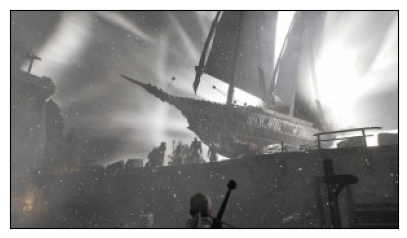

In [94]:
# 显示图片
def show(x):
    # 还原normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(1)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(1)
    x = x * std + mean

    # c,w,h转换为w,h,c
    x = x.permute(1, 2, 0)

    # 还原到0-255
    x *= 255

    x = x.numpy().astype(np.uint8)
    x = PIL.Image.fromarray(x, mode='RGB')
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x)
    plt.show()

show(x)

# 定义数据集类

In [95]:
# 定义数据集
class Dataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.x = []
        self.y = []

        for file in files:
            self.x.append(file)
            self.y.append(int(file[0]))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x = load_file(self.x[i])
        y = self.y[i]
        if y == 2:
            y = 1
        return x, torch.tensor(y)


dataloader_train = torch.utils.data.DataLoader(dataset=Dataset(files_train),
                                               batch_size=50,
                                               shuffle=True,
                                               drop_last=True)

dataloader_test = torch.utils.data.DataLoader(dataset=Dataset(files_test),
                                              batch_size=50,
                                              shuffle=True,
                                              drop_last=True)

for i, (x, y) in enumerate(dataloader_train):
    break

x.shape, y.shape

(torch.Size([50, 3, 169, 300]), torch.Size([50]))

# 训练模型

In [108]:
# 使用torchvision提供的训练好的resnet模型'
resnet = torchvision.models.resnet50(weights=None)
resnet_state_dict = torch.load(f"{model_path}/resnet/resnet50-0676ba61.pth", weights_only=True)
resnet.load_state_dict(resnet_state_dict)

# 剪掉最后一层
resnet = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*resnet)

# 不需要计算梯度
resnet.eval()

# 试算
out = resnet(x)
out.shape

torch.Size([50, 2048, 1, 1])

In [113]:
# 迁移学习模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=2048, out_features=512),
            torch.nn.ReLU(), 
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=2))

    def forward(self, x):
        return self.fc(x)


model = Model()
model(out.squeeze()).shape

torch.Size([50, 2])

In [114]:
# 训练模型
def train(train_resnet=False, num_epochs=10, patience=2):
    optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-4)
    optimizer_resnet18 = torch.optim.Adam(resnet.parameters(), lr=1e-6)
    criteon = torch.nn.CrossEntropyLoss()

    best_loss = float('inf')  # 初始best_loss很大
    trigger_times = 0         # 连续patience次没有提升就停
    best_model_state = None

    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        resnet.eval()
        if train_resnet:
            resnet.train()

        total_loss = 0
        total_correct = 0
        total_samples = 0

        for i, (x, y) in enumerate(dataloader_train):
            optimizer_model.zero_grad()
            optimizer_resnet18.zero_grad()

            # forward
            out = resnet(x)
            out = out.view(out.size(0), -1)
            out = model(out)

            loss = criteon(out, y)
            loss.backward()

            optimizer_model.step()
            if train_resnet:
                optimizer_resnet18.step()

            total_loss += loss.item()
            preds = out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            if i % 10 == 0:
                acc = (preds == y).sum().item() / float(y.size(0))
                print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}] Loss: {loss.item():.4f} Acc: {acc*100:.2f}%")

        # 验证模式，统计验证集loss
        model.eval()
        val_loss = 0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
            for x_val, y_val in dataloader_test:
                out_val = resnet(x_val)
                out_val = out_val.view(out_val.size(0), -1)
                out_val = model(out_val)

                loss_val = criteon(out_val, y_val)
                val_loss += loss_val.item()

                preds_val = out_val.argmax(dim=1)
                val_correct += (preds_val == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= len(dataloader_test)
        val_acc = val_correct / val_total

        print(f"==> Epoch [{epoch+1}/{num_epochs}] Finished! Train Loss: {total_loss/len(dataloader_train):.4f}, Train Acc: {total_correct/total_samples*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%\n")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
            print(f"Trigger Times: {trigger_times}")

            if trigger_times >= patience:
                print("Early stopping!")
                break

    # 恢复最好的模型参数
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 保存模型
    torch.save(model.state_dict(), f'{model_path}/zdan/model.mdl')
    print("Best model saved!")


# 训练模型
train()


Epoch [1/10] Step [0] Loss: 0.7094 Acc: 46.00%
